<a href="https://colab.research.google.com/github/DineshChopra/AI-ML/blob/master/TensorFlow/Udacity/6_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub and Transfer Learning

## Concepts that will be covered in this colab
1. Use a TensorFlow Hub model for prediction
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset
3. Do simple transfer learning with TensorFlow Hub

In [17]:
import tensorflow as tf

In [18]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [19]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

## Download the classifier

In [20]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
  hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Run it on a Single Image

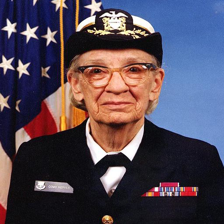

In [21]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [22]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [23]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [24]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the prediction

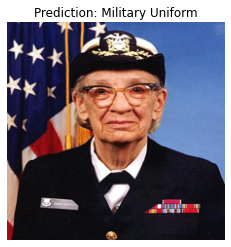

In [25]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

#Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

## Dataset

In [26]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [27]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [28]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

In [29]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'Egyptian cat', 'lynx', 'Italian greyhound',
       'Appenzeller', 'tabby', 'Bernese mountain dog',
       'American Staffordshire terrier', 'otterhound', 'tabby', 'weasel',
       'Egyptian cat', 'toy terrier', 'lens cap', 'French bulldog',
       'tennis ball', 'Egyptian cat', 'schipperke', 'grey fox',
       'Egyptian cat', 'Angora', 'Chihuahua',
       'American Staffordshire terrier', 'Labrador retriever',
       'Labrador retriever', 'tabby', 'kelpie', 'Newfoundland',
       'tiger cat', 'English springer', 'kelpie', 'tiger cat'],
      dtype='<U30')

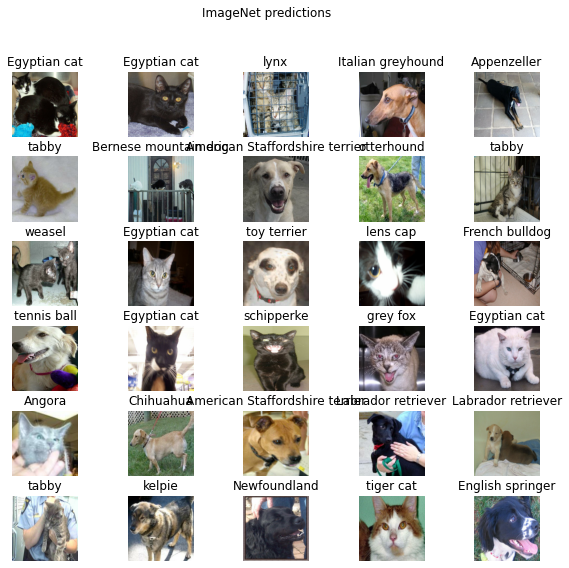

In [30]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

In [31]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

In [ ]:
feature_extractor.trainable = False

## Attach a classification head

In [32]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 56s 97ms/step - loss: 0.0538 - accuracy: 0.9812 - val_loss: 0.0341 - val_accuracy: 0.9882
Epoch 2/6
582/582 [==============================] - 55s 94ms/step - loss: 0.0295 - accuracy: 0.9898 - val_loss: 0.0329 - val_accuracy: 0.9888
Epoch 3/6
582/582 [==============================] - 54s 93ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.0311 - val_accuracy: 0.9901
Epoch 4/6
582/582 [==============================] - 55s 94ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0344 - val_accuracy: 0.9875
Epoch 5/6
582/582 [==============================] - 55s 95ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0325 - val_accuracy: 0.9901
Epoch 6/6
582/582 [==============================] - 55s 94ms/step - loss: 0.0169 - accuracy: 0.9940 - val_loss: 0.0329 - val_accuracy: 0.9903


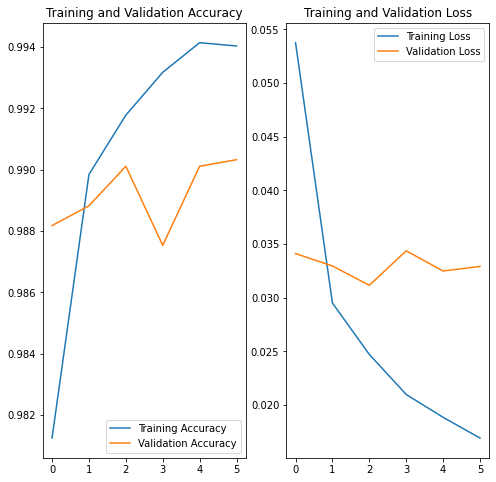

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [36]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog',
       'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat',
       'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog',
       'dog', 'cat', 'dog', 'dog', 'cat'], dtype='<U3')

In [38]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0]
Predicted labels:  [0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0]


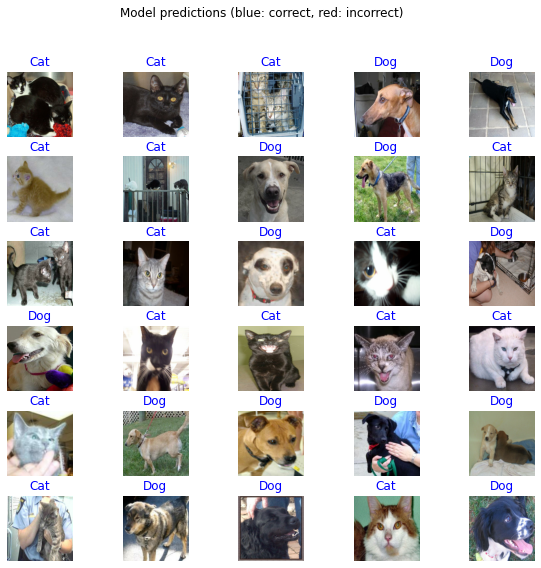

In [39]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")